<a href="https://colab.research.google.com/github/vdelapuentea/PROYECTO-PUCP/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importacion de librerias



In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import OneHotMeanIoU

import os
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Versión de tensorflow

In [2]:
tf.__version__

'2.8.2'

# **Lectura de datos** 

Con este código listamos todos los archivos que tenemos en el dataset


In [3]:
dataset_path = Path("/content/drive/MyDrive/PROYECTO-PUCP/data")
list(dataset_path.iterdir())

[PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/class_dict.csv'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/val'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/train_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/train'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/CamVid'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/test_labels'),
 PosixPath('/content/drive/MyDrive/PROYECTO-PUCP/data/test')]

In [4]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')       
#tree(dataset_path)

In [68]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [69]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

Con este código asignamos una variable a cada archivo.




In [5]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))



((421, 421), (112, 112), (168, 168))

# **Configuración de Parametros**


In [6]:
img_size = 128
IMAGE_SIZE = img_size 
BATCH_SIZE = 4

In [7]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [8]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [9]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [10]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

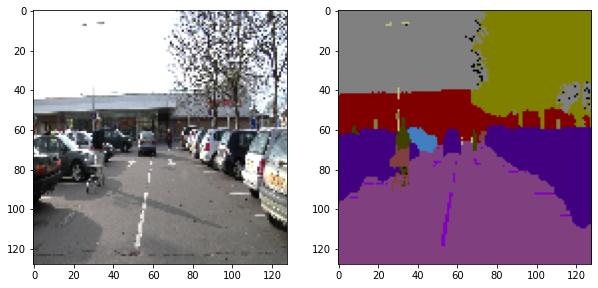

In [49]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [47]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

In [13]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

32

In [14]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [15]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [16]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 2,  4,  5,  8, 10, 12, 15, 16, 17, 19, 20, 21, 22, 24, 26, 27, 30,
        31], dtype=uint8),
 array([  12, 1517,  358,  560,   15,  184,  514,  188, 2858,  941,   13,
        2160,  121, 1049, 3024,  230, 1615, 1025]))

## **Creación de la Clase de DataGenerator**




In [17]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=BATCH_SIZE, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = len(class_map)) #class_map <- parametrizar
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [18]:
train_generator = DataGenerator(train_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

105

In [19]:
test_generator = DataGenerator(test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = train_generator.__len__()
test_generator

105

In [20]:
X,y = train_generator.__getitem__(1)
y.shape

(4, 128, 128, 32)

In [21]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

28

# **Estructura del la red neuronal UNET**

In [22]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=32, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [23]:
model = Unet(img_size , img_size , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

# **Configuración de hiperparametros**


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes= 32, name=None, dtype=None)])

In [25]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=20, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=20,verbose=1,mode="max",min_lr=0.0001) #min_lr=0.0001
cv = CSVLogger("logs/log.csv" , append=True , separator=',')

# **Entrenamiento del modelo**

In [26]:
results = model.fit_generator(train_generator  ,steps_per_epoch=train_steps ,epochs=200,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,tb,rl,cv])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
105/105 [==============================] - ETA: 0s - loss: 1.3530 - accuracy: 0.6425 - one_hot_mean_io_u: 0.0833
Epoch 1: val_accuracy improved from -inf to 0.54089, saving model to top-weights.h5
105/105 [==============================] - 952s 9s/step - loss: 1.3530 - accuracy: 0.6425 - one_hot_mean_io_u: 0.0833 - val_loss: 2.8147 - val_accuracy: 0.5409 - val_one_hot_mean_io_u: 0.0589 - lr: 0.0010
Epoch 2/200
105/105 [==============================] - ETA: 0s - loss: 0.8998 - accuracy: 0.7447 - one_hot_mean_io_u: 0.1345
Epoch 2: val_accuracy improved from 0.54089 to 0.70413, saving model to top-weights.h5
105/105 [==============================] - 34s 327ms/step - loss: 0.8998 - accuracy: 0.7447 - one_hot_mean_io_u: 0.1345 - val_loss: 1.1282 - val_accuracy: 0.7041 - val_one_hot_mean_io_u: 0.0992 - lr: 0.0010
Epoch 3/200
105/105 [==============================] - ETA: 0s - loss: 0.7871 - accuracy: 0.7762 - one_hot_mean_io_u: 0.1622
Epoch 3: val_accuracy improved from 0.7041

# Guardamos el modelo 

In [39]:
# model.save('modelUnet.h5')
# print('Model Saved!')

Model Saved!


# Cargamos el modelo guardado

In [ ]:
savedModel=load_model('modelUnet.h5')
#savedModel.summary()

# Comparación de la etiqueta con lo predicho



Text(0.5, 1.0, 'predicted labels')

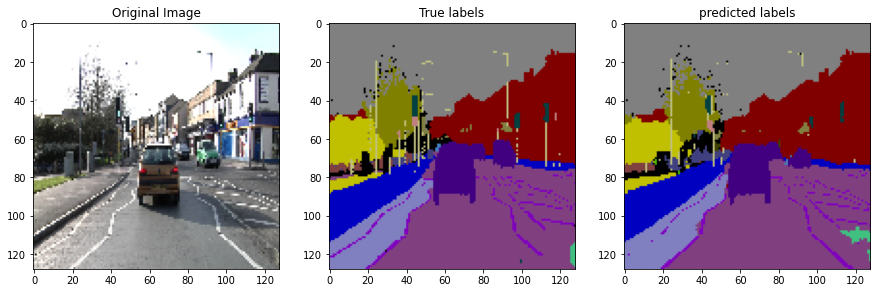

In [70]:
#img_mask = choice(val_pair)
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0016E5_01320.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0016E5_01320_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

Text(0.5, 1.0, 'predicted labels')

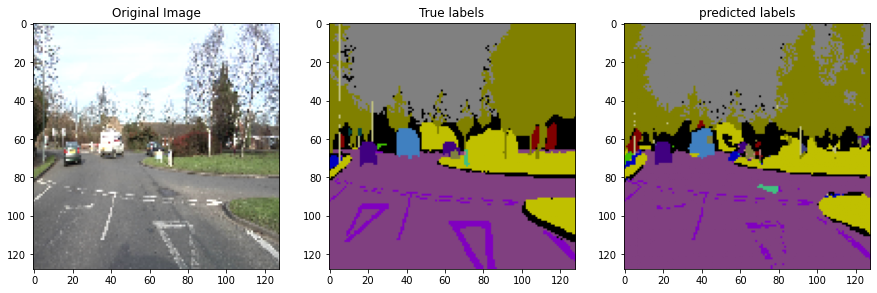

In [71]:
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0006R0_f01050.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0006R0_f01050_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

Text(0.5, 1.0, 'predicted labels')

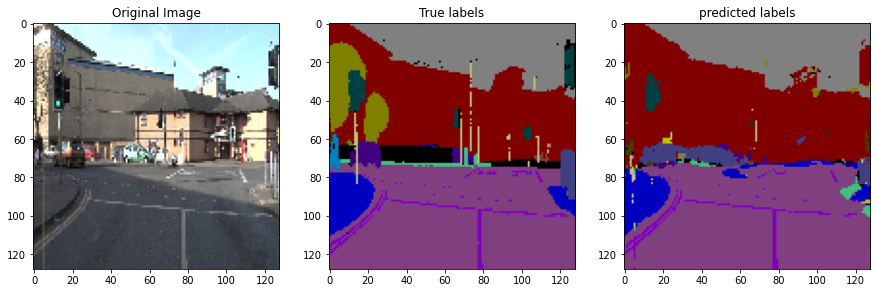

In [72]:
img_mask = (Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val/0016E5_00510.png'),
            Path('/content/drive/MyDrive/PROYECTO-PUCP/data/val_labels/0016E5_00510_L.png'))
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

pred_label = make_prediction(savedModel, img_mask[0], (img_size,img_size,3))
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')